## Задача 1

$$\sum_{i=1}^n q_{h(x)} (X_i - x) (Y_i - a(x) - b(x)(X_i - x))^2 \rightarrow min$$
Перепишем это в матричном виде.
Заметим, что $Y - (X - x 1_n) (a(x), b(x))^T = \left(\matrix {Y_1 - a(x) b(x)(X_1 - x) \\ ....\\ Y_n - a(x) b(x)(X_n - x)}\right)$

где $1_n = (1, 1, ..., 1)^T$ длины n 

Пусть $ W = \left(\matrix { q_{h(x)} (X_1 - x) & 0 & 0& ... & 0 \\
                            0 & q_{h(x)} (X_2 - x) & 0 & ... & 0 \\
                            &&&...........&& \\
                            0 & 0 & 0 & ... & q_{h(x)} (X_n - x)} \right) $
                            
Тогда получим $$||W^{\frac{1}{2}} (Y - (1_n, X - x 1_n)) (a(x), b(x))^T||_2^2 \rightarrow min$$

$$(a(x), b(x))^T = ((1_n, X - x 1_n)^T W (1_n, X - x 1_n))^{-1} (1_n, X - x 1_n)^T W Y$$

## Задача 2

In [83]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels as sm
import scipy.stats as sps
from scipy.stats import pearsonr, t
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.interpolate import UnivariateSpline

from scipy.stats import f
import seaborn as sns
import copy
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [29]:
data = pd.read_csv('glass.dat', sep=' *')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,WinF
2,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,WinF
3,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,WinF
4,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,WinF
5,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,WinF


Выберем сначала оптимальную ширину окна. Для этого посмотрим на разную ширину и гистограмму.

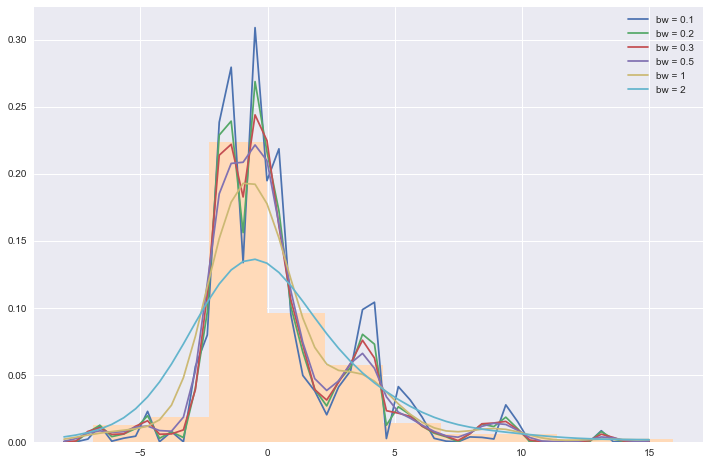

In [52]:
RI = np.array(data.RI)

plt.figure(figsize = (12, 8))
dens = sm.nonparametric.kde.KDEUnivariate(RI)
for bw in [0.1, 0.2, 0.3, 0.5, 1, 2]:
    dens.fit(bw = bw, kernel = 'gau')
    plt.hist(RI, normed=True, color='peachpuff')
    plt.plot(np.linspace(-8,15), dens.evaluate(np.linspace(-8,15)), label = 'bw = {}'.format(bw))
plt.legend()
plt.show()

Выберем ширину окна 0.5

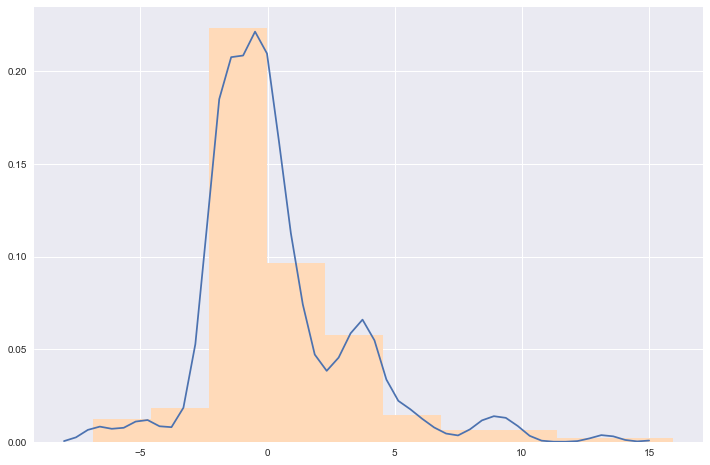

In [53]:
plt.figure(figsize = (12, 8))
dens.fit(bw = 0.5, kernel = 'gau')
plt.hist(RI, normed=True,color='peachpuff')
plt.plot(np.linspace(-8,15), dens.evaluate(np.linspace(-8,15)), label = 'bw = {}'.format(bw))
plt.show()

Для построения дов. интервала вспомним теорему из лекции. 
$$p_n^*(z) = p_{Z_n} + \frac{\xi_n(z)}{\sqrt{n h_n}}$$
где $\xi_n(z) \xrightarrow{d} \xi(z) \sim N(0, \alpha p(z))$, $\alpha = 1$ для гауссовского ядра.

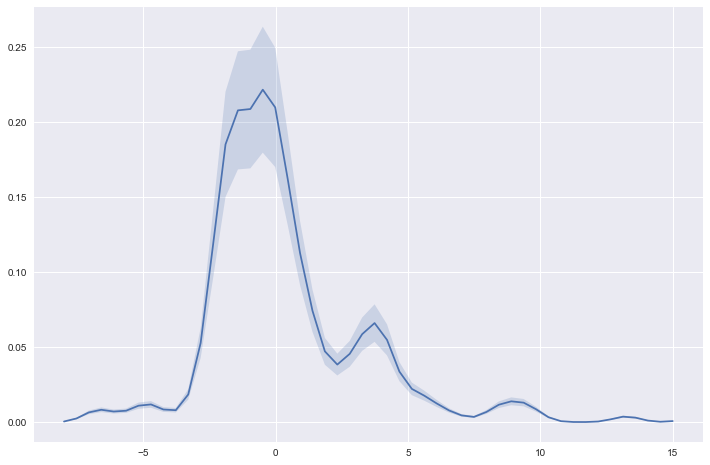

In [58]:
dens = sm.nonparametric.kde.KDEUnivariate(RI)
dens.fit(bw = 0.5, kernel = 'gau')
kde = dens.evaluate(np.linspace(-8,15))
interval = sps.norm.interval(0.95,
                             loc=0, scale=kde) / (np.sqrt(len(sample) * 0.5))
plt.figure(figsize = (12, 8))
# plt.hist(RI, normed=True,color='peachpuff')
plt.plot(np.linspace(-8,15), kde, label = 'bw = {}'.format(bw))
plt.fill_between(np.linspace(-8,15), interval[0]+kde, interval[1]+kde, alpha=0.2)
plt.show()

## Задача 3

In [69]:
data = pd.read_csv('hw10t3.csv')
data.head()

,Unnamed: 0,y,x
0,0,0.064771,0.180249
1,1,-0.683449,-0.811201
2,2,0.501485,-0.616333
3,3,0.263588,-0.749556
4,4,-0.323165,-0.414561


Класс для вычисления оценки Надарая-Ватсона

In [61]:
class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]


Построим оценку Надарая-Ватсона при различных bandwidth

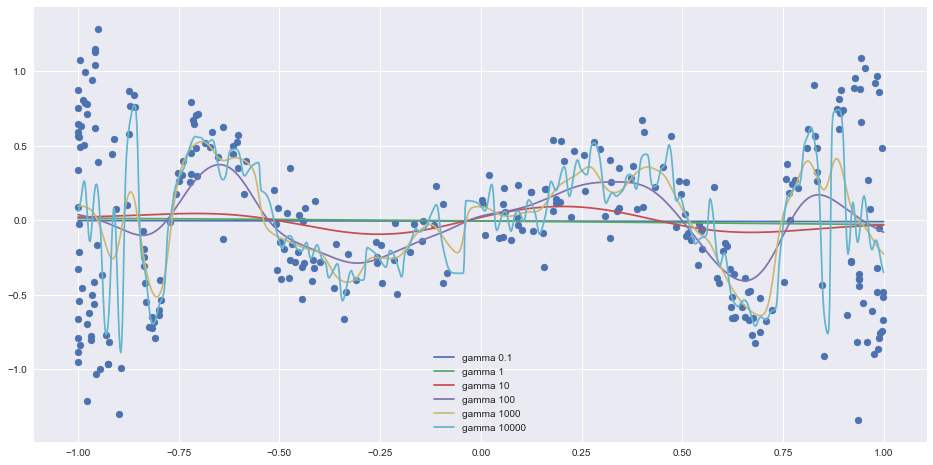

In [80]:
X = np.array(data.x)
y = np.array(data.y)
grid = np.linspace(-1, 1, 1000)

plt.figure(figsize = (16, 8))

for g in [0.1, 1, 10, 100, 1000, 10000]:
    model = KernelRegression(gamma = g)
    model.fit(X[:,np.newaxis], y)
    plt.plot(grid, model.predict(grid[:,np.newaxis]), label = 'gamma ' + str(g))
    
plt.scatter(X, y)
plt.legend()
plt.show()

Видим, что при слишком большом параметре bandwidth мы переобучаемся, а при слишком маленьком - наоборот. Оптимальное значение - 100-1000

Построим оценку сглаживающего сплайна.

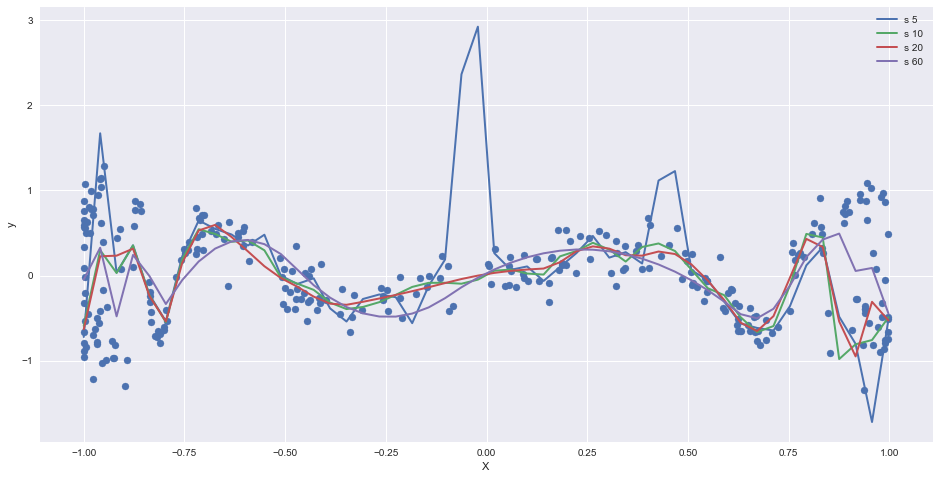

In [98]:
ind_sort = np.argsort(X)
X_sort = X[ind_sort]
y_sort = y[ind_sort]
grid = np.linspace(min(X_sort),max(X_sort))
plt.figure(figsize = (16, 8))

for s in [5, 10, 20, 60]:
    spline = UnivariateSpline(X_sort, y_sort, s=s, k=2)
    plt.plot(grid, spline(grid), label = 's ' + str(s), lw=2)
    
plt.scatter(X_sort, y_sort)
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Судя по графику самым оптимальным является сглаживающий параметр s= 10.

Нарисуем оценку Надарая-Ватсона и сглаживающего сплайна.

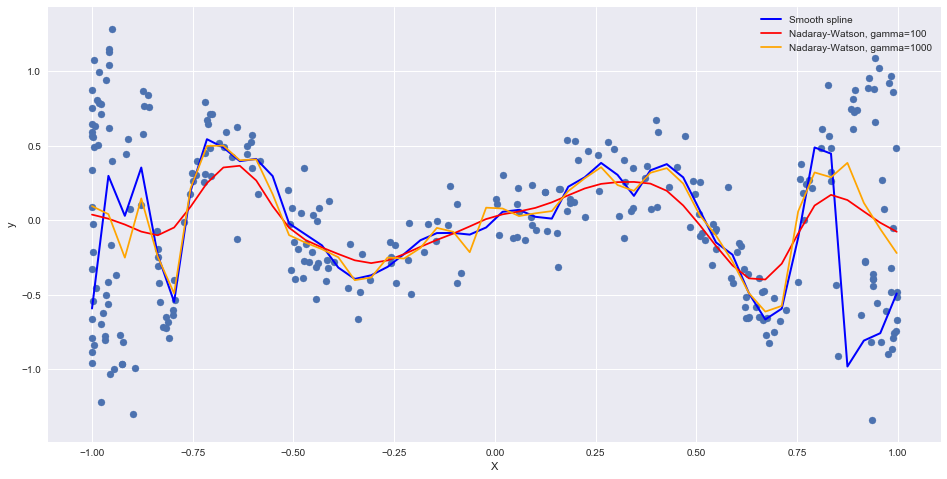

In [105]:
plt.figure(figsize = (16, 8))

spline = UnivariateSpline(X_sort, y_sort, s=10, k=2)
plt.plot(grid, spline(grid), label = 'Smooth spline', lw=2, color='blue')
model = KernelRegression(gamma = 100)
model.fit(X[:,np.newaxis], y)
plt.plot(grid, model.predict(grid[:,np.newaxis]), label = 'Nadaray-Watson, gamma=100', color='red')
model = KernelRegression(gamma = 1000)
model.fit(X[:,np.newaxis], y)
plt.plot(grid, model.predict(grid[:,np.newaxis]), label = 'Nadaray-Watson, gamma=1000', color='orange')



plt.scatter(X_sort, y_sort)
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

На графиках видим, что оценка Надарая-Ватсона получается более гладкой, чем оценка сглаживающего сплайна. Также можно заметить, что из-за большей гладкости оценки Надарая-Ватсона, она хуже пресказывает на интервале [0.75, 1.0]

Интегралы квадрата второй производной в сглаживающий сплайн мы добавляем как регуляризатор.